# YouTubeDataset Examples


In [1]:
import torch
import torchvision.transforms as vTransforms
import torchvision.utils as vUtils

import torchtext
import torchtext.vocab
import torchtext.data


import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

import librosa
import librosa.display as lrd

from YouTubeDataset import YouTubeDataset
from YouTubeDataset import transforms as ytTransforms
from YouTubeDataset import utils as ytUtils

import av

# YouTubeDataset requires a Google Cloud API Key with YouTube Data API V3 access to
# download a dataset
#
# API Key from https://console.cloud.google.com/apis/credentials
# 

from MYAPIKEY import API_KEY

/home/john/anaconda3/envs/inno-virt-char/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


## Default Dataset

Video frames as images, timestamp


Files already downloaded
['IMAGE', 'TIME']
IMAGE torch.float32 torch.Size([3, 128, 128])
TIME <class 'float'> 0.0


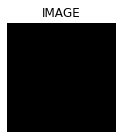

In [2]:
from YouTubeDataset import YouTubeDataset

class MyTransform():
    def __init__(self):
        pass
        
    def __call__(self, x):
        print(x.dtype, x.shape)
        return x
    


transform = vTransforms.Compose([
     vTransforms.ToPILImage(),
     vTransforms.Resize((128, 128)),
     vTransforms.ToTensor()
])


ds0 = YouTubeDataset('data', 'SecretLocation', 'train', image_transform = transform,
                    download=True,
                    api_key=API_KEY,
                    user_name='thesecretlocation',
                    splits={'train':0.90, 'test':0.1})                  

ytUtils.ipd_display_dataset(ds0)

### With Dataloader


['IMAGE', 'TIME']
IMAGE torch.float32 torch.Size([32, 3, 128, 128])
TIME torch.float64 torch.Size([32])


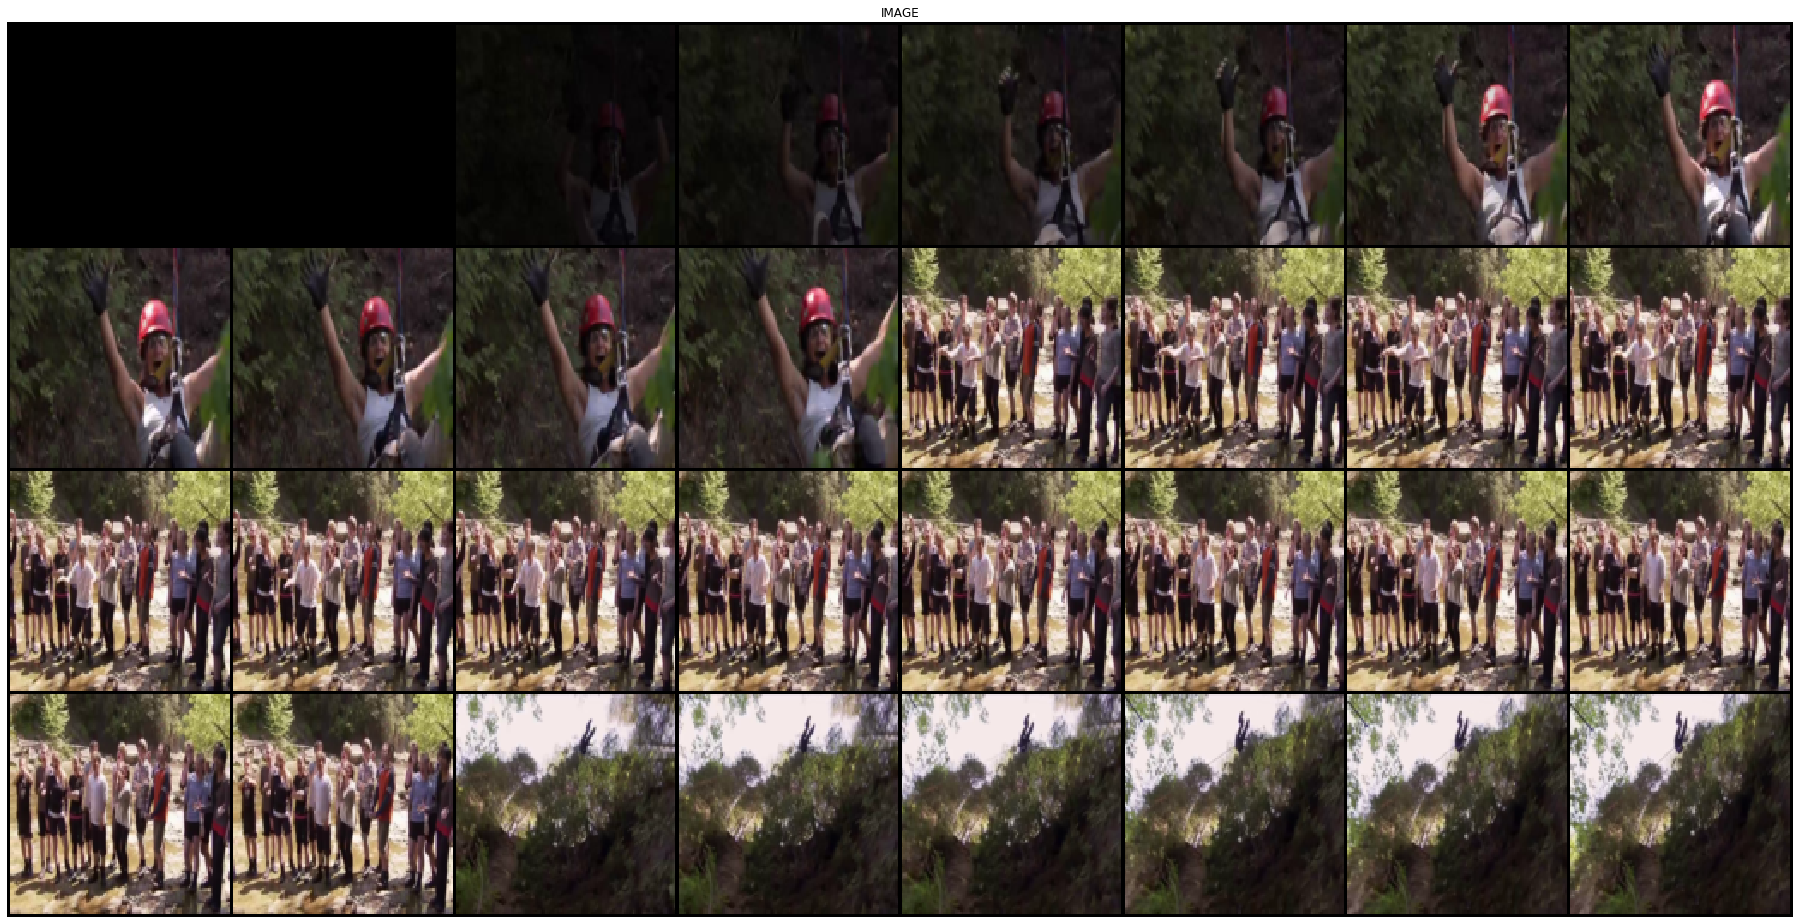

In [3]:
ds0_loader = torch.utils.data.DataLoader(ds0, batch_size=32)

ytUtils.ipd_display_dataset(ds0_loader)


## Audio Training Dataset

Training dataset for TTS, audio is aligned with text (uses captioning timestamps)

timestamp, text, audio buffer

In [4]:
#
# Custom Embedding function to embed text strings with word vectors
#
class MyFastTextEmbedding():
    def __init__(self, max_token_len=32, tokenizer="basic_english", language="en"):
        
        self.tokenizer = torchtext.data.get_tokenizer(tokenizer, language=language)
        self.vocab = torchtext.vocab.FastText(language=language)
        self.max_token_len = max_token_len

    def __call__(self, text):
        tokens = self.tokenizer(text)
        vec = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)
        pvec = torch.nn.functional.pad(vec, (0,0,self.max_token_len - vec.shape[0],0))
        return pvec

#
# Audio Transform to zero pad audio segment
#
class MyAudioTransform():
    def __init__(self, max_audio_len=0):
        self.max_audio_len = max_audio_len
        
    def __call__(self, audio):
        audio = torch.nn.functional.pad(audio, (0, self.max_audio_len - audio.shape[1]))
        return audio
    
ds1 = YouTubeDataset('data', 'SecretLocation', 'train', 
                    fields=[YouTubeDataset.F_TIME,  YouTubeDataset.F_CC_TEXT, YouTubeDataset.F_AF_DATA],
                    key=YouTubeDataset.F_CC_TEXT)
ds1.text_transform = MyFastTextEmbedding(max_token_len=64)
ds1.audio_transform = MyAudioTransform(max_audio_len=int(ds1.max_text_dur * ds1.audio_sr))

['TIME', 'TEXT', 'AUDIO']
TIME <class 'float'> 0.0
TEXT torch.float32 torch.Size([64, 300])
AUDIO torch.float32 torch.Size([1, 403040])


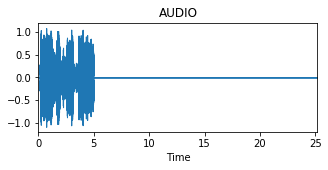

In [5]:
ytUtils.ipd_display_dataset(ds1)

### With Dataloader

['TIME', 'TEXT', 'AUDIO']
TIME torch.float64 torch.Size([4])
TEXT torch.float32 torch.Size([4, 64, 300])
AUDIO torch.float32 torch.Size([4, 1, 403040])


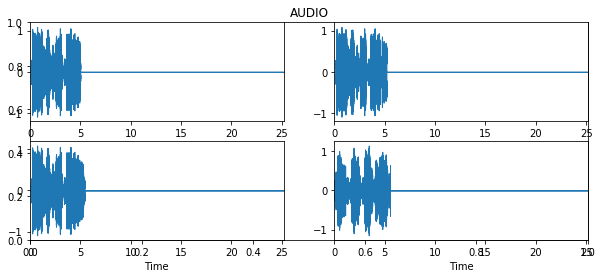

In [6]:
ds1_loader = torch.utils.data.DataLoader(ds1, batch_size=4)

ytUtils.ipd_display_dataset(ds1_loader)

## Video Captioning Dataset

Training Dataset for video captioning

timestamp, text, video_frames with video frames aligned to text and padded

In [7]:

ds2 = YouTubeDataset('data', 'SecretLocation', 'train', 
                    video_cliplen=64,
                    fields=[YouTubeDataset.F_TIME,  YouTubeDataset.F_CC_TEXT, YouTubeDataset.F_VF_DATA],
                    key=YouTubeDataset.F_CC_TEXT)                  

ytUtils.ipd_display_dataset(ds2)

['TIME', 'TEXT', 'VIDEO']
TIME <class 'float'> 0.0
TEXT <class 'str'> in the groundbreaking YTV reality series
VIDEO torch.uint8 torch.Size([64, 360, 640, 3])


## Video, Audio, Text Dataset

timestamp, 5s video segment, audio, text aligned to video segment

['TIME', 'VIDEO', 'AUDIO', 'TEXT']
TIME <class 'float'> 0.0
VIDEO torch.uint8 torch.Size([64, 360, 640, 3])
AUDIO torch.float32 torch.Size([1, 42666])
TEXT <class 'str'> in the groundbreaking YTV reality series


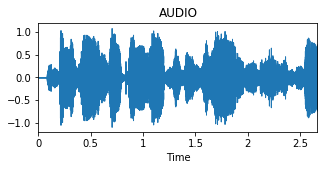

In [8]:
ds3 = YouTubeDataset('data', 'SecretLocation', 'train', 
                    fields=[YouTubeDataset.F_TIME,  YouTubeDataset.F_VF_DATA, YouTubeDataset.F_AF_DATA, YouTubeDataset.F_CC_TEXT ],
                    key=YouTubeDataset.F_VF_DATA,
                    video_cliplen=64)                  

ytUtils.ipd_display_dataset(ds3)

## Video, Audio, Text Dataset

timestamp, duration, text, video segment, and audio, all aligned to the text

['TIME', 'DURATION', 'TEXT', 'VIDEO', 'AUDIO']
TIME <class 'float'> 0.0
DURATION <class 'float'> 4.98
TEXT <class 'str'> in the groundbreaking YTV reality series
VIDEO torch.uint8 torch.Size([119, 360, 640, 3])
AUDIO torch.float32 torch.Size([1, 79680])


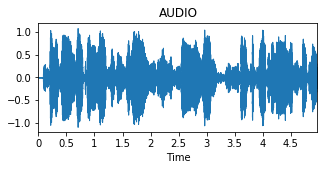

In [9]:
   
ds4 = YouTubeDataset('data', 'SecretLocation', 'train', 
                    video_framerate=24,
                    fields=['TIME', 'DURATION', 'TEXT', 'VIDEO', 'AUDIO'],
                    key='TEXT')
ytUtils.ipd_display_dataset(ds4)

## Video, Audio, Text Dataset

timestamp, duration, text, video segment, and audio, all aligned to the text and padded to the max duration of the text

In [10]:
# To use a DataLoader we need to pad all the variable length frames

#
# Custom Embedding function to embed text strings with word vectors
#
class MyFastTextEmbedding():
    def __init__(self, max_token_len=32, tokenizer="basic_english", language="en"):
        
        self.tokenizer = torchtext.data.get_tokenizer(tokenizer, language=language)
        self.vocab = torchtext.vocab.FastText(language=language)
        self.max_token_len = max_token_len

    def __call__(self, text):
        tokens = self.tokenizer(text)
        vec = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)
        pvec = torch.nn.functional.pad(vec, (0,0,self.max_token_len - vec.shape[0],0))
        return pvec

#
# Audio Transform to zero pad audio segment
#
class MyAudioPad():
    def __init__(self, max_audio_len=0):
        self.max_audio_len = max_audio_len
        
    def __call__(self, audio): # (K,L)
        audio = torch.nn.functional.pad(audio, (0, self.max_audio_len - audio.shape[1]))
        return audio

#
# Video Transform to zero pad video segment
#
class MyVideoPad():
    def __init__(self, max_video_len=0):
        self.max_video_len = max_video_len
        
    def __call__(self, video): # (T,H,W,C)
        video = torch.nn.functional.pad(video, (0,0, 0,0, 0,0, 0,self.max_video_len - video.shape[0]))
        return video

print('max_text_len', ds4.max_text_len)
print('max_text_dur', ds4.max_text_dur)
print('max_text_tokens',ds4.max_text_tokens(torchtext.data.get_tokenizer(tokenizer="basic_english", language="en")))

ds4.text_transform = MyFastTextEmbedding(max_token_len=ds4.max_text_tokens(torchtext.data.get_tokenizer(tokenizer="basic_english", language="en")))
ds4.audio_transform = MyAudioPad(max_audio_len=int(ds4.max_text_dur * ds4.audio_sr))
ds4.video_transform = MyVideoPad(max_video_len=int(ds4.max_text_dur * ds4.video_framerate))


max_text_len 40
max_text_dur 25.19
max_text_tokens 15


['TIME', 'DURATION', 'TEXT', 'VIDEO', 'AUDIO']
TIME <class 'float'> 0.0
DURATION <class 'float'> 4.98
TEXT torch.float32 torch.Size([15, 300])
VIDEO torch.uint8 torch.Size([604, 360, 640, 3])
AUDIO torch.float32 torch.Size([1, 403040])


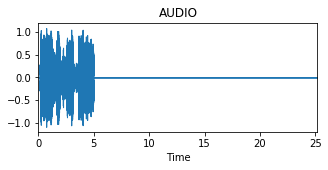

In [11]:
ytUtils.ipd_display_dataset(ds4)

## With Dataloader

['TIME', 'DURATION', 'TEXT', 'VIDEO', 'AUDIO']
TIME torch.float64 torch.Size([2])
DURATION torch.float64 torch.Size([2])
TEXT torch.float32 torch.Size([2, 15, 300])
VIDEO torch.uint8 torch.Size([2, 604, 360, 640, 3])
AUDIO torch.float32 torch.Size([2, 1, 403040])


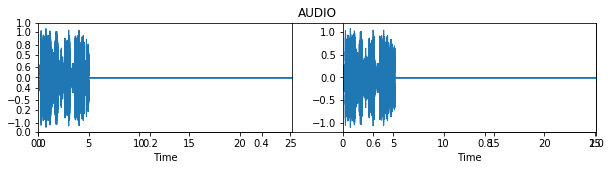

In [12]:
ds4_loader = torch.utils.data.DataLoader(ds4, batch_size=2)

ytUtils.ipd_display_dataset(ds4_loader)